In [1]:
import os
import sys
import pygame
import random
from pygame import *
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

pygame.init()



# window details
scr_size = (width,height) = (600,600)
FPS = 60
gravity = 5

# colors
black = (0,0,0)
white = (255,255,255)
background_col = (235,235,235)

high_score = 0

screen = pygame.display.set_mode(scr_size)
x = np.array(pygame.surfarray.array2d(screen))
x = x/max(1,x.max())
x = x.swapaxes(0,1)
# print(x)

clock = pygame.time.Clock()
pygame.display.set_caption("Dino Run")

# sounds added 
jump_sound = pygame.mixer.Sound('templates/jump.wav')
die_sound = pygame.mixer.Sound('templates/die.wav')
checkPoint_sound = pygame.mixer.Sound('templates/checkPoint.wav')

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# returns pygame.image and rectangle(size) of image 
def load_image( name,sizex=-1,sizey=-1,colorkey=None,):

    fullname = os.path.join('templates', name)
    image = pygame.image.load(fullname)
    image = image.convert()
    if colorkey is not None:
        if colorkey is -1:
            colorkey = image.get_at((0, 0))
        image.set_colorkey(colorkey, RLEACCEL)

    if sizex != -1 or sizey != -1:
        image = pygame.transform.scale(image, (sizex, sizey))

    return (image, image.get_rect())


## slice the big image into n different sub images
# returns array of subimages and size of whole sheet
def load_sprite_sheet(
        sheetname,
        nx,
        ny,
        scalex = -1,
        scaley = -1,
        colorkey = None,
        ):
    fullname = os.path.join('templates',sheetname)
    sheet = pygame.image.load(fullname)
    sheet = sheet.convert()
    

    sheet_rect = sheet.get_rect()
    # print(sheet_rect)

    templates = []

    # nx subimages
    sizex = sheet_rect.width/nx
    sizey = sheet_rect.height/ny

    for i in range(0,ny):
        for j in range(0,nx):
            rect = pygame.Rect((j *sizex,i*sizey,sizex,sizey))
            image = pygame.Surface(rect.size)
            image = image.convert()
            image.blit(sheet,(0,0),rect)

            if colorkey is not None:
                if colorkey is -1:
                    colorkey = image.get_at((0,0))
                image.set_colorkey(colorkey,RLEACCEL)

            if scalex != -1 or scaley != -1:
                image = pygame.transform.scale(image,(scalex,scaley))
                

            templates.append(image)
            # print(len(templates))

    ## get rectangle of one sub_image
    sprite_rect = templates[0].get_rect()

    return templates,sprite_rect




## shows two images - 'game over' and 'return button' after game over.
def disp_gameOver_msg(retbutton_image,gameover_image):
    retbutton_rect = retbutton_image.get_rect()
    retbutton_rect.centerx = width / 2
    retbutton_rect.top = height*0.52

    gameover_rect = gameover_image.get_rect()
    gameover_rect.centerx = width / 2
    gameover_rect.centery = height*0.35

    screen.blit(retbutton_image, retbutton_rect)
    screen.blit(gameover_image, gameover_rect)



# if  number = 457 then output = [0 0 4 5 7] (list)
def extractDigits(number):
    if number > -1:
        digits = []
        while(number/10 != 0):
            digits.append(number%10)
            number = int(number/10)

        digits.append(number%10)
        for i in range(len(digits),5):
            digits.append(0)
        digits.reverse()
        return digits





class Dino():
    def __init__(self,sizex=-1,sizey=-1):
        
        ### array of dino sub images
        self.images,self.rect = load_sprite_sheet('dino.png',5,1,sizex,sizey,-1)
        # print(len(self.images))
        
        ### array of dino_ducking sub images
        self.images1,self.rect1 = load_sprite_sheet('dino_ducking.png',2,1,59,sizey,-1)
        
        # set position of dino i.e., lower left corner
        self.rect.bottom = int(0.98*height)  ### lowermost
        self.rect.left = width/15    #### leftmost

        
        self.image = self.images[0]
        self.index = 0
        self.counter = 0    
        self.score = 0
        self.reward = 0
        self.isJumping = False
        self.isDead = False
        self.isDucking = False
        self.isBlinking = False
        self.movement = [0,0]   ### x , y
        self.jumpSpeed = 24

        self.stand_pos_width = self.rect.width
        
        self.duck_pos_width = self.rect1.width


    ####   ???????????
    def draw(self):
        screen.blit(self.image,self.rect)

      ## if dino is jumping or not
    def checkbounds(self):
        if self.rect.bottom > int(0.98*height):
            self.rect.bottom = int(0.98*height)
            self.isJumping = False

    def update(self):
        if self.isJumping:
            self.movement[1] = self.movement[1] + gravity   

        if self.isJumping:
            self.index = 0   ## ?? I think index = 0 denotes dino is jumping and first image of dino.png
            
        elif self.isBlinking:
            if self.index == 0:
                if self.counter % 400 == 399:
                    self.index = (self.index + 1)%2
            else:
                if self.counter % 20 == 19:
                    self.index = (self.index + 1)%2

        elif self.isDucking:
            if self.counter % 5 == 0:
                self.index = (self.index + 1)%2
        else:
            if self.counter % 5 == 0:
                self.index = (self.index + 1)%2 + 2

        if self.isDead:
            self.index = 4


        if not self.isDucking:
            self.image = self.images[self.index]
            # print(self.index)  2 3 4 2 3 4 (running) (dino.png)
            self.rect.width = self.stand_pos_width
        else:   ### Ducking
            self.image = self.images1[(self.index)%2]
            self.rect.width = self.duck_pos_width

        self.rect = self.rect.move(self.movement)
        self.checkbounds()

        ## self.counter % 7 decides the speed of score 
        if not self.isDead and self.counter % 7 == 6 and self.isBlinking == False:
            self.score += 1
            # if score is multiple of 100 then make a sound 
            if self.score % 100 == 0 and self.score != 0:
                if pygame.mixer.get_init() != None:
                    checkPoint_sound.play()

        self.counter = (self.counter + 1)

class Cactus(pygame.sprite.Sprite):
    def __init__(self,speed=5,sizex=-1,sizey=-1):
        pygame.sprite.Sprite.__init__(self,self.containers)
        self.images,self.rect = load_sprite_sheet('cacti-small.png',3,1,sizex,sizey,-1)
        self.rect.bottom = int(0.98*height)
        self.rect.left = width + self.rect.width
        self.image = self.images[random.randrange(0,3)]
        self.movement = [-1*speed,0]

    def draw(self):
        screen.blit(self.image,self.rect)

    def update(self):
        self.rect = self.rect.move(self.movement)

        ## ?????
        if self.rect.right < 0:
            self.kill()

class Ptera(pygame.sprite.Sprite):
    
    
    def __init__(self,speed=5,sizex=-1,sizey=-1):
        pygame.sprite.Sprite.__init__(self,self.containers)
        self.images,self.rect = load_sprite_sheet('ptera.png',2,1,sizex,sizey,-1)
        self.ptera_height = [height*0.82,height*0.75,height*0.60]
        self.rect.centery = self.ptera_height[random.randrange(0,3)]
        self.rect.left = width + self.rect.width
        self.image = self.images[0]
        self.movement = [-1*speed,0]
        self.index = 0
        self.counter = 0

    def draw(self):
        screen.blit(self.image,self.rect)

    def update(self):
        if self.counter % 10 == 0:
            self.index = (self.index+1)%2
        self.image = self.images[self.index]
        self.rect = self.rect.move(self.movement)
        self.counter = (self.counter + 1)
        if self.rect.right < 0:
            self.kill()


class Ground():
    def __init__(self,speed=-5):
        self.image,self.rect = load_image('ground.png',-1,-1,-1)
        self.image1,self.rect1 = load_image('ground.png',-1,-1,-1)
        self.rect.bottom = height
        self.rect1.bottom = height
        self.rect1.left = self.rect.right
        self.speed = speed

    # show ground
    def draw(self):
        screen.blit(self.image,self.rect)
        screen.blit(self.image1,self.rect1)
        pass

    ##  moving ground
    def update(self):
        self.rect.left += self.speed
        self.rect1.left += self.speed

        if self.rect.right < 0:
            self.rect.left = self.rect1.right

        if self.rect1.right < 0:
            self.rect1.left = self.rect.right

class Cloud(pygame.sprite.Sprite):
    def __init__(self,x,y):
        pygame.sprite.Sprite.__init__(self,self.containers)
        self.image,self.rect = load_image('cloud.png',int(90*30/42),30,-1)
        self.speed = 1
        self.rect.left = x
        self.rect.top = y
        self.movement = [-1*self.speed,0]

    def draw(self):
        screen.blit(self.image,self.rect)

    def update(self):
        self.rect = self.rect.move(self.movement)
        if self.rect.right < 0:
            self.kill()




class Scoreboard():
    def __init__(self,x=-1,y=-1):
        self.score = 0
        self.tempimages,self.temprect = load_sprite_sheet('numbers.png',12,1,11,int(11*6/5),-1)
        self.image = pygame.Surface((55,int(11*6/5)))
        self.rect = self.image.get_rect()
        if x == -1:
            self.rect.left = width*0.89
        else:
            self.rect.left = x
        if y == -1:
            self.rect.top = height*0.1
        else:
            self.rect.top = y

    def draw(self):
        screen.blit(self.image,self.rect)

    def update(self,score):
        score_digits = extractDigits(score)
        # print(score_digits)
        self.image.fill(background_col)
        for s in score_digits:
            self.image.blit(self.tempimages[s],self.temprect)
            self.temprect.left += self.temprect.width
        self.temprect.left = 0



In [3]:
class Environment:


    def __init__(self):
        self.gamespeed = 16
        self.startMenu = False
        self.gameOver = False
        self.gameQuit = False

        self.playerDino = Dino(44,47)
        self.new_ground = Ground(-1*self.gamespeed)
        self.scb = Scoreboard()
        self.highsc = Scoreboard(width*0.78)
        self.counter = 0

        self.cacti = pygame.sprite.Group()
        self.pteras = pygame.sprite.Group()
        self.clouds = pygame.sprite.Group()
        self.last_obstacle = pygame.sprite.Group()

        Cactus.containers = self.cacti
        Ptera.containers = self.pteras
        Cloud.containers = self.clouds

        self.retbutton_image,self.retbutton_rect = load_image('replay_button.png',35,31,-1)
        self.gameover_image,self.gameover_rect = load_image('game_over.png',190,11,-1)

        self.temp_images,self.temp_rect = load_sprite_sheet('numbers.png',12,1,11,int(11*6/5),-1)
        self.HI_image = pygame.Surface((22,int(11*6/5)))
        self.HI_rect = self.HI_image.get_rect()
        self.HI_image.fill(background_col)
        self.HI_image.blit(self.temp_images[10],self.temp_rect)
        self.temp_rect.left += self.temp_rect.width
        self.HI_image.blit(self.temp_images[11],self.temp_rect)
        self.HI_rect.top = height*0.1
        self.HI_rect.left = width*0.73
        
        screen.fill(background_col)
        self.new_ground.draw()
        self.clouds.draw(screen)
        self.scb.draw()
        if high_score != 0:
            self.highsc.draw()
            screen.blit(self.HI_image,self.HI_rect)
        self.cacti.draw(screen)
        self.pteras.draw(screen)
        self.playerDino.draw()
        pygame.display.update()
        
        #INITIALIZE PREV STATE
        self.prev = deque([])
        x = np.array(pygame.surfarray.array2d(screen))
        x = x/max(1,x.max())
        x = x.swapaxes(0,1)
        for i in range(4):
            self.prev.append(x) 
            
        self.nearest = -1
    
    def update(self):
        
        for c in self.cacti:
            c.movement[0] = -1*self.gamespeed
            if self.nearest == -1 :
                self.nearest = c.rect.right
            #LOGIC FOR COLLISION
            if pygame.sprite.collide_mask(self.playerDino,c):
                self.playerDino.isDead = True
                if pygame.mixer.get_init() != None:
                    die_sound.play()
        
        for p in self.pteras:
            p.movement[0] = -1*self.gamespeed
            if pygame.sprite.collide_mask(self.playerDino,p):
                self.playerDino.isDead = True
                if pygame.mixer.get_init() != None:
                    die_sound.play()
            

        if len(self.cacti) < 2:
            if len(self.cacti) == 0:
                self.last_obstacle.empty()
                self.last_obstacle.add(Cactus(self.gamespeed,40,40))
            else:
                for l in self.last_obstacle:
                    if l.rect.right < width*0.7 and random.randrange(0,50) == 10:
                        self.last_obstacle.empty()
                        self.last_obstacle.add(Cactus(self.gamespeed, 40, 40))

        if len(self.pteras) == 0 and random.randrange(0,200) == 10 and self.counter > 500:
            for l in self.last_obstacle:
                if l.rect.right < width*0.8:
                    self.last_obstacle.empty()
                    self.last_obstacle.add(Ptera(self.gamespeed, 46, 40))

        if len(self.clouds) < 5 and random.randrange(0,300) == 10:
            Cloud(width,random.randrange(height/5,height/2))

        self.playerDino.update()
        self.cacti.update()
        self.pteras.update()
        self.clouds.update()
        self.new_ground.update()
        self.scb.update(self.playerDino.score)
        self.highsc.update(high_score)
        
        
        if pygame.display.get_surface() != None:
            screen.fill(background_col)
            self.new_ground.draw()
            self.clouds.draw(screen)
            self.scb.draw()
            if high_score != 0:
                self.highsc.draw()
                screen.blit(self.HI_image,self.HI_rect)
            self.cacti.draw(screen)
            self.pteras.draw(screen)
            self.playerDino.draw()

            pygame.display.update()
        
        
        return
    


    def render(self, WINDOW =None, human = False, actions = [0,0]):
        
        clock = pygame.time.Clock()
    
        global high_score
        
        action = 0
        if actions[1] == 1 :
            action =1
        
        if action == 1:
            if self.playerDino.rect.bottom == int(0.98*height):
                self.playerDino.isJumping = True
                if pygame.mixer.get_init() != None:
                    jump_sound.play()
                self.playerDino.movement[1] = -1*self.playerDino.jumpSpeed   
            #move 10 frames = number of frames required to jump    
            for i in range(10):
                self.update()
                if self.gameOver:
                    break
                clock.tick(40)
                    
        if action == 0:
            self.update()
            clock.tick(60)
            
            
        
        
        #get the next state after completing the action
        x2 = np.array(pygame.surfarray.array2d(screen))
        x2 = x2/max(1,x2.max())
        x2 = x2.swapaxes(0,1)
        


        
        if not self.playerDino.isDead: #this next state will be the new previous state
            if action == 1:
                for i in range(4):
                    self.prev.popleft()
                for i in range(4):
                    self.prev.append(x2)
            else :
                self.prev.popleft()
                self.prev.append(x2)
        
        
            
            
        rew = 0
        if self.playerDino.isDead :
            rew = -50
            self.gameOver = True
            #FORGOT TO ADD THE BELOW LINE AND TRAINED FOR 90k steps ...F
#             scores_df.loc[len(loss_df)] = self.playerDino.score
            if self.playerDino.score > high_score:
                high_score = self.playerDino.score
            self.__init__()
        else :
            rew = 1
              
        
        self.nearest = -1
        return x2,rew ,self.gameOver
        

Run the below code to get a sense of previous state and next state for a time step. I have implemented steps in a manner that if the action is of jumping, then the next action can be taken only after the jump is completed. So previous state for a jump and next state for the jump will be the start of the jump and the end of the jump. 

In [4]:
# clock = pygame.time.Clock()

# c = 0 
# arr_prev = []
# arr_next = []
# nst = 0
# rew = 0
# gover = 0

# env = Environment()
# img = env.prev[0]
# for i in range(1,4):
#     img += env.prev[i]
# arr_prev.append(img)
# nst,rew,gover = env.render(actions= [0,0])



# while c < 20:
    
#     #PREV STATE FOR THIS STEP
#     img = env.prev[0]
#     for i in range(1,4):
#         img += env.prev[i]
#     arr_prev.append(img)
    
#     #DECIDE ACTION
#     actions = [0,1]
# #     if c%50 == 0:
# #         actions = [0,1]
#     c+=1    
    
#     nst,rew,gover = env.render(actions=actions)
#     #NEXT STATE FOR AN ACTION IN THIS STATE
#     arr_next.append(nst)
    
# #     clock.tick(40)

In [5]:
# fig = plt.figure(figsize=(50,50))

# k =0
# for i in range(k,k+20,2):
#     plt.subplot(10,2,i-k+1)
#     img1 = arr_prev[i]
#     plt.imshow(img1,cmap='gray')
#     plt.subplot(10,2,i-k+2)
#     img2 = arr_next[i]
#     plt.imshow(img2,cmap='gray')

In [6]:
import numpy as np
from PIL import Image
import cv2 #opencv
import io
import time
import pandas as pd
import numpy as np
from IPython.display import clear_output
from random import randint
import os

#keras imports
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard
from collections import deque
import random
import pickle
from io import BytesIO
import base64
import json

Using TensorFlow backend.
/home/ajinkya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ajinkya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ajinkya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ajinkya/anaconda3/lib/python3.7/site-packages/t

In [7]:
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f: #dump files into objects folder
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    x = 0
    path = 'objects/' + name + '.pkl'
    if os.path.getsize(path)>0:
        with open(path, 'rb') as f:
            f.seek(0)
            x = pickle.load(f)
            f.close()
    return x

def process_img(image):
    image = image[300:600, :500] #Crop Region of Interest(ROI)
    image = cv2.resize(image, (80,80))
    return  image


In [8]:
loss_file_path = "./objects/loss_df.csv"
actions_file_path = "./objects/actions_df.csv"
q_value_file_path = "./objects/q_values.csv"
scores_file_path = "./objects/scores_df.csv"

In [9]:
#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])
q_values_df =pd.read_csv(actions_file_path) if os.path.isfile(q_value_file_path) else pd.DataFrame(columns = ['qvalues'])

In [10]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.99 # decay rate of past observations original 0.99
OBSERVATION = 100. # timesteps to observe before training
EXPLORE = 100000  # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 2000 # number of previous transitions to remember
BATCH = 16 # size of minibatch
FRAME_PER_ACTION = 4
LEARNING_RATE = 1e-4
img_rows , img_cols = 80,80
img_channels = 4 #We stack 4 frames

In [11]:
# training variables saved as checkpoints to filesystem to resume training from the same step
def init_cache():
    """initial variable caching, done only once"""
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    D = deque()
    save_obj(D,"D")

In [12]:
# init_cache() #run this only once to initialize cache

In [13]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (8, 8), padding='same',strides=(4, 4),input_shape=(img_cols,img_rows,img_channels)))  #80*80*4
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4),strides=(2, 2),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3),strides=(1, 1),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    
    #create model file if not present
    if not os.path.isfile(loss_file_path):
        model.save_weights('modelf.h5')
    print("We finish building the model")
    return model


In [17]:
''' 
main training module
Parameters:
* model => Keras Model to be trained
* game_state => Game State module with access to game environment and dino
* observe => flag to indicate wherther the model is to be trained(weight updates), else just play
'''
def trainNetwork(model,observe=False):
    
    
    last_time = time.time()
    if observe == False:
        # store the previous observations in replay memory
        D = load_obj("D") #load from file system

    # get the first state by doing nothing
    do_nothing = np.zeros(ACTIONS) #actions =2 , defined above
    do_nothing[0] =1 #0 => do nothing,
                     #1=> jump
    
    x_t, r_0, terminal = env.render(actions = do_nothing) # get next step after performing the action
    for i in range(4):
        env.prev.popleft()
        env.prev.append(x_t)
        
    x_t = process_img(x_t)
    
    r_0 = 0.1
    if terminal == True:
            r_t = -10
    

        
    s_t = np.stack((x_t,x_t,x_t,x_t), axis=2) # stack 4 images to create placeholder input
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*20*40*4
    initial_state = s_t 

    
    t = 0
    if observe :
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("modelf.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon") 
        model.load_weights("modelf.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        t = load_obj("time") # resume from the previous time step stored in file system

    
    
    while (True): #endless running

        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0 
        a_t = np.zeros([ACTIONS]) 
        

        #choose an action epsilon greedy
        if  random.random() <= epsilon: #randomly explore an action
            print("----------Random Action----------")
            action_index = random.randrange(ACTIONS)
            a_t[action_index] = 1
        else: # predict the output
            q = model.predict(s_t)       #input a stack of 4 images, get the prediction
            max_Q = np.argmax(q)         # chosing index with maximum q value
            action_index = max_Q 
            a_t[action_index] = 1        # o=> do nothing, 1=> jump

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = env.render(actions = a_t)
        
        if observe == False:
            #We reduced the epsilon (exploration parameter) gradually
            if epsilon > FINAL_EPSILON and t > OBSERVE:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 


            #FORGOT TO ADD THE BELOW LINE

            actions_df.loc[len(actions_df)] = a_t[1] #if its a 0 then the action was 0, if its a 1 then action was 1!

            

            last_time = time.time()


            x_t1 = process_img(x_t1)
            x_t1 = np.stack((x_t1,x_t1,x_t1,x_t1), axis=2)
            x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], x_t1.shape[2]) 

            for i in range(4):

                s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # append the new image to input stack and remove the first one

            s_t1 = x_t1

            #store the transition in D
            D.append((s_t, action_index, r_t, s_t1, terminal))

            if len(D) > REPLAY_MEMORY:
                D.popleft()

        #only train if done observing
        if t > OBSERVE and t%5 == 0: 
            if observe == True:
                pass
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]    # 4D stack of images
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]   #reward at state_t due to action_t
                state_t1 = minibatch[i][3]   #next state
                terminal = minibatch[i][4]   #wheather the agent died or survided due the action
                

                inputs[i:i + 1] = state_t    

                targets[i] = model.predict(state_t)  # predicted q values
                Q_sa = model.predict(state_t1)      #predict q values for next step
                
                if terminal:
                    targets[i, action_t] = reward_t # if terminated, only equals reward
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            #WEIGHTS UPDATE
            loss += model.train_on_batch(inputs, targets)
            
            loss_df.loc[len(loss_df)] = loss
            q_values_df.loc[len(q_values_df)] = np.max(Q_sa)
            
        if terminal:
            s_t = initial_state #reset game to initial frame if terminate
        else :
            arr = []
            for i in range(4):
                img = env.prev[i]
                img =process_img(img)
                arr.append(img)
            s_t = np.stack((arr[0],arr[1],arr[2],arr[3]), axis=2) # stack 4 images to create placeholder input
            s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2]) 

            
        t = t + 1
        
        if observe==True:
            continue
        # save progress every 1000 iterations
        if t % 1000 == 0:
            
            print("Now we save model")
            
            model.save_weights("modelf.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            q_values_df.to_csv(q_value_file_path,index=False)
            with open("modelf.json", "w") as outfile:
                json.dump(model.to_json(), outfile)
            clear_output()

            
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state,             "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,             "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")


In [18]:
#main function
env = Environment()
def playGame(observe=False):
    model = buildmodel()
    trainNetwork(model,observe=observe)
    

In [19]:
playGame(True)

Now we build the model
We finish building the model
Now we load weight
Weight load successfully


KeyboardInterrupt: 

Run the below code to get a sense of the replay/experience memory. In the figure, in each row, left image is the previous state before some action and the right image is the next state after that action.
Note - The prev_state at t+1 th time step will be the next_state from the t th time step. They will not look exactly the same, color wise, explanation I'll give later.

In [111]:
D = load_obj("D")
mb = []
for i in range(800,900):
    mb.append(D[i])

In [112]:
len(mb)

100

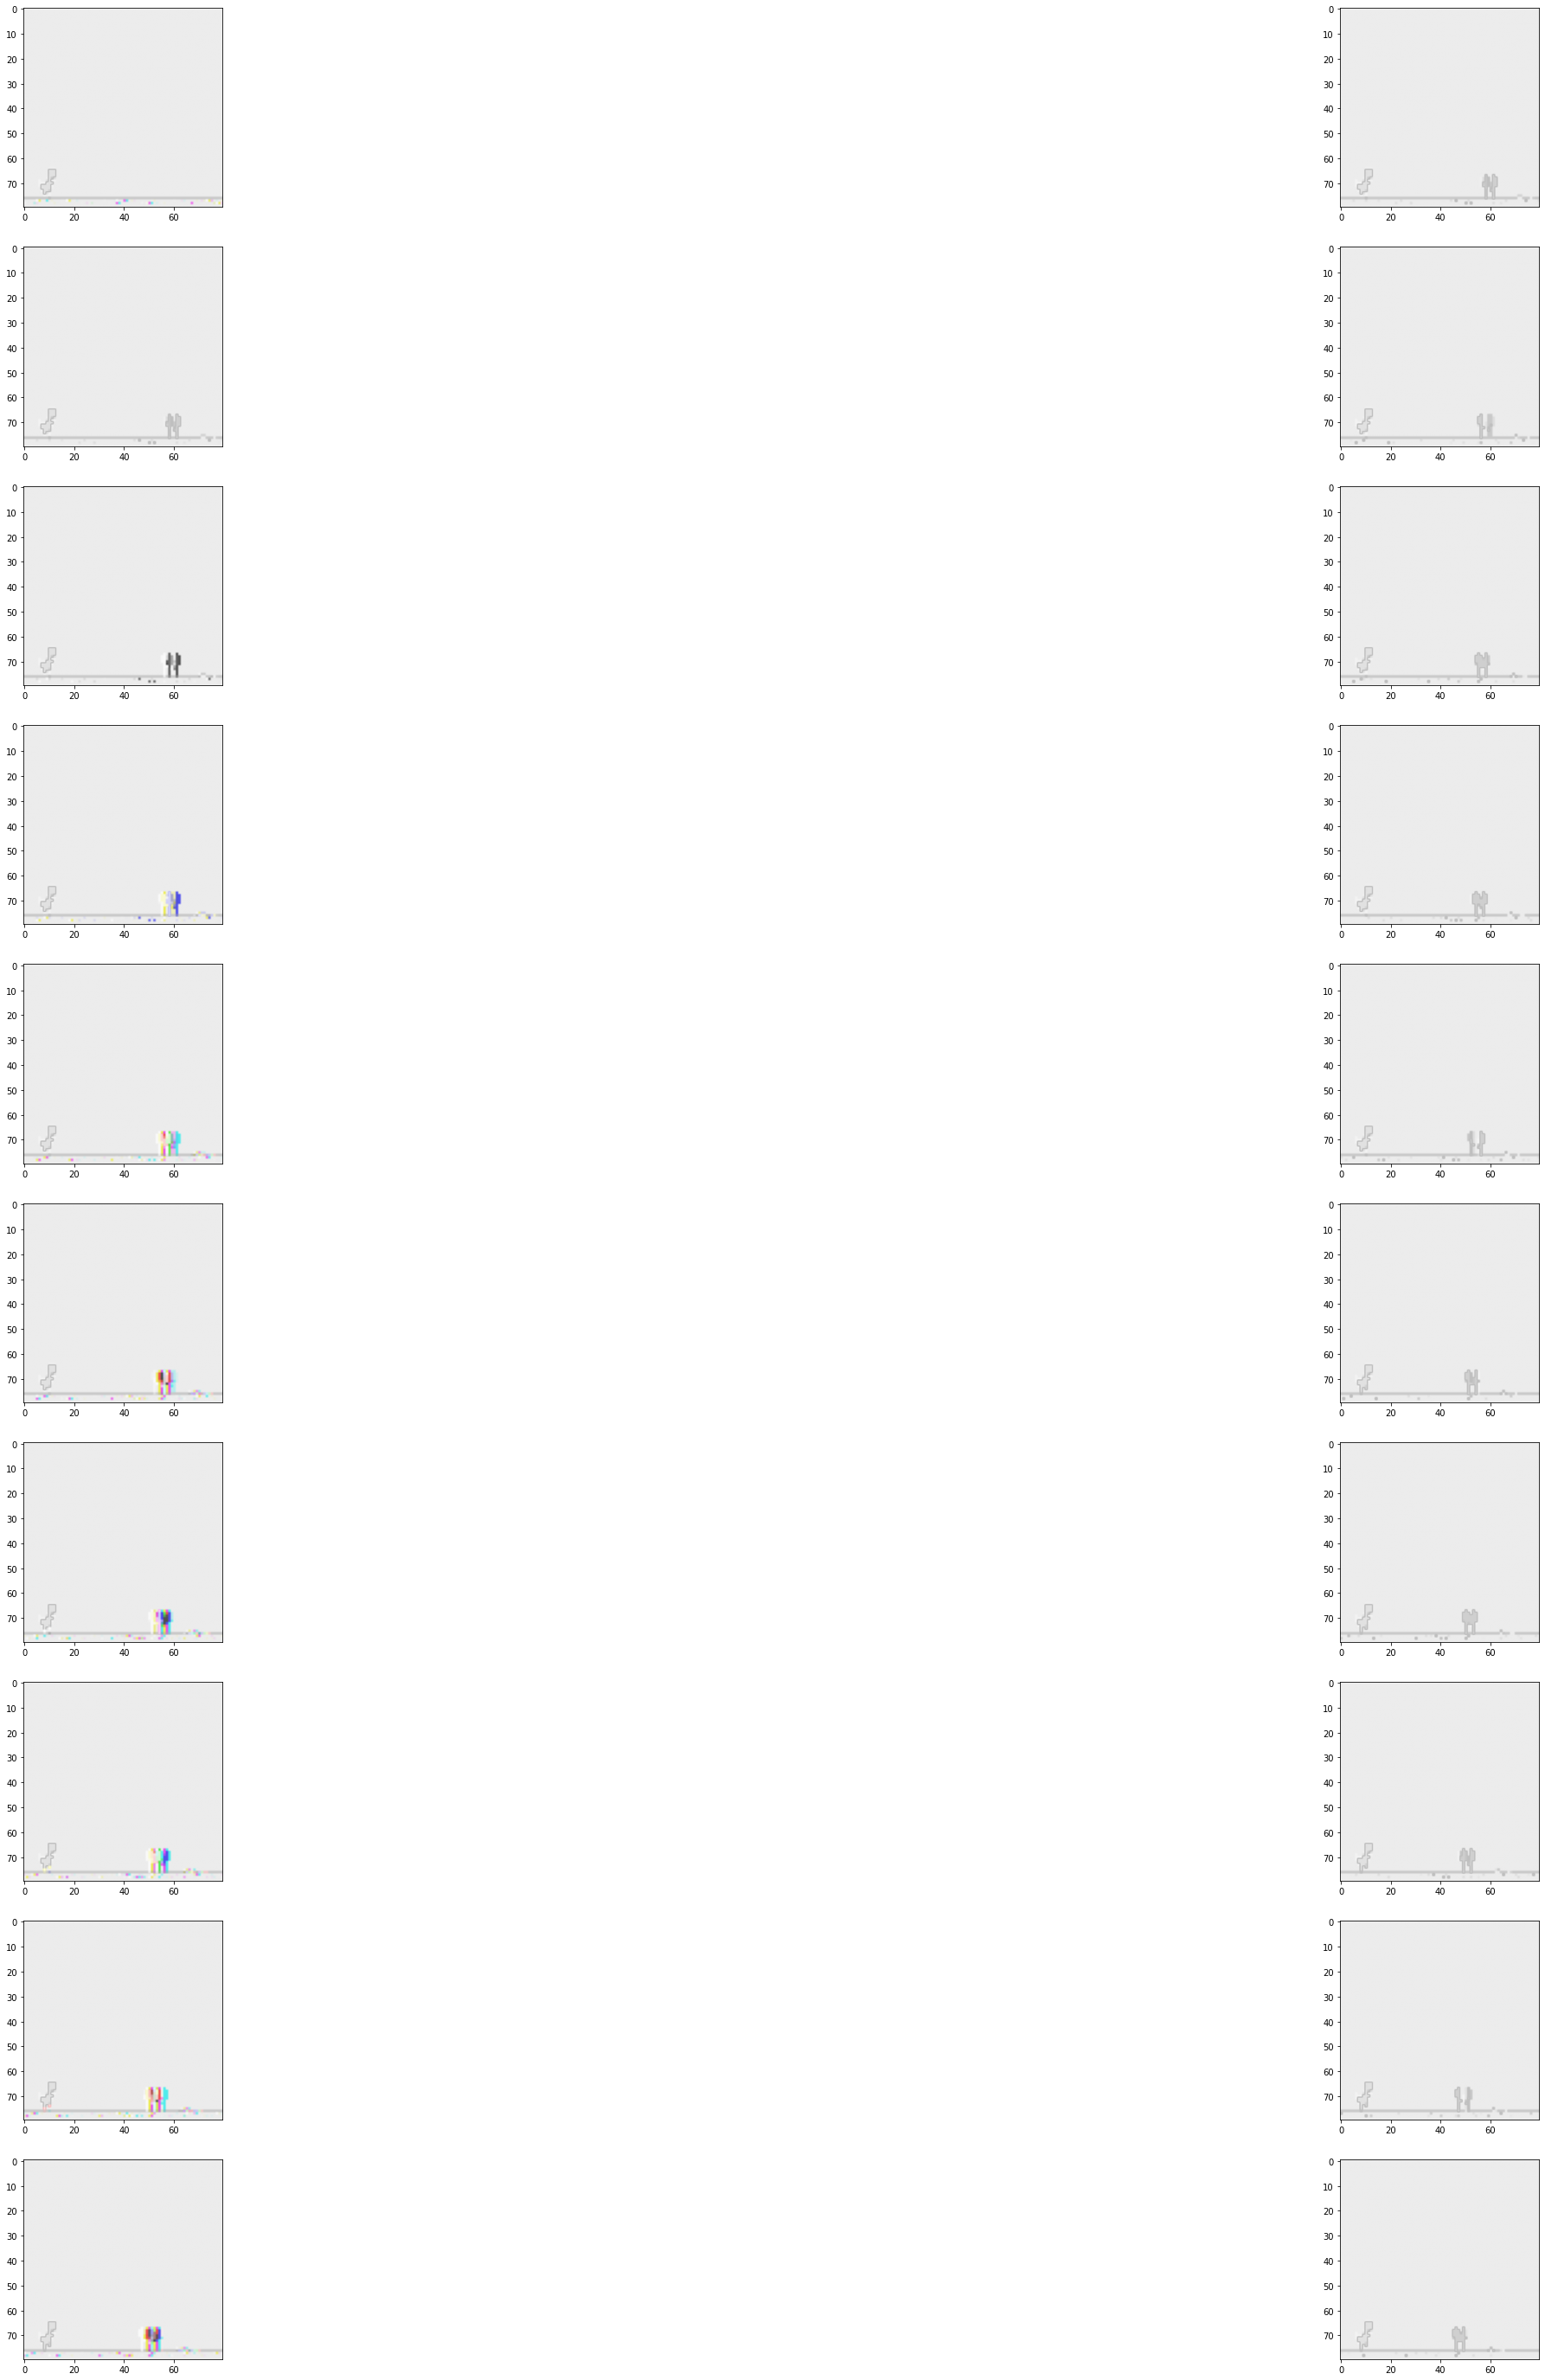

In [113]:
fig = plt.figure(figsize=(50,50))

k = 0
for i in range(0,10):
    plt.subplot(10,2,2*i + 1)
    plt.imshow(mb[i+10][0][0])
    plt.subplot(10,2,2*i + 2)
    plt.imshow(mb[i+10][3][0])

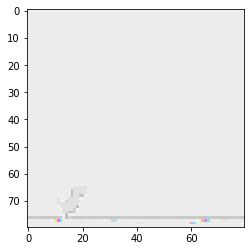

In [95]:
plt.imshow(mb[99][0][0])

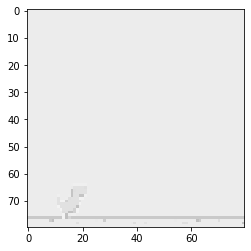

In [96]:
plt.imshow(mb[98][3][0])

In [134]:
pip install seaborn

     |████████████████████████████████| 285 kB 5.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [135]:
import time
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)
import seaborn as sns
import pandas as pd
import numpy as np

<AxesSubplot:>

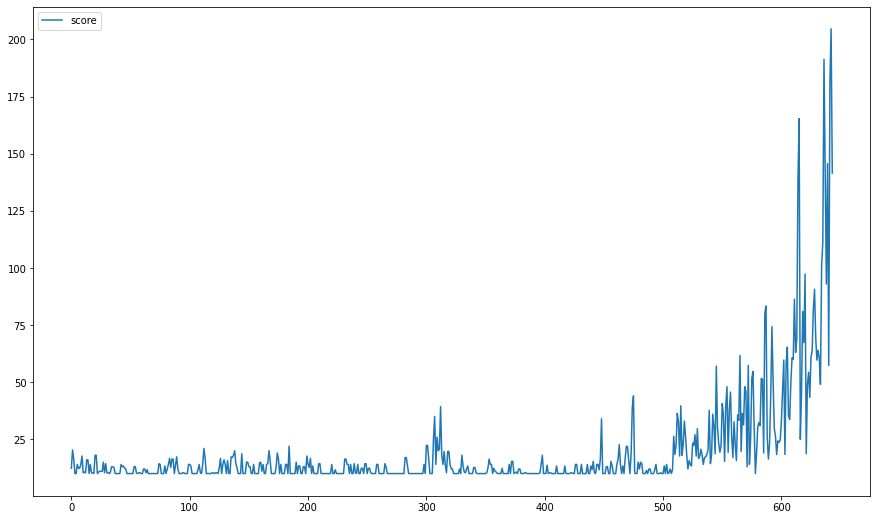

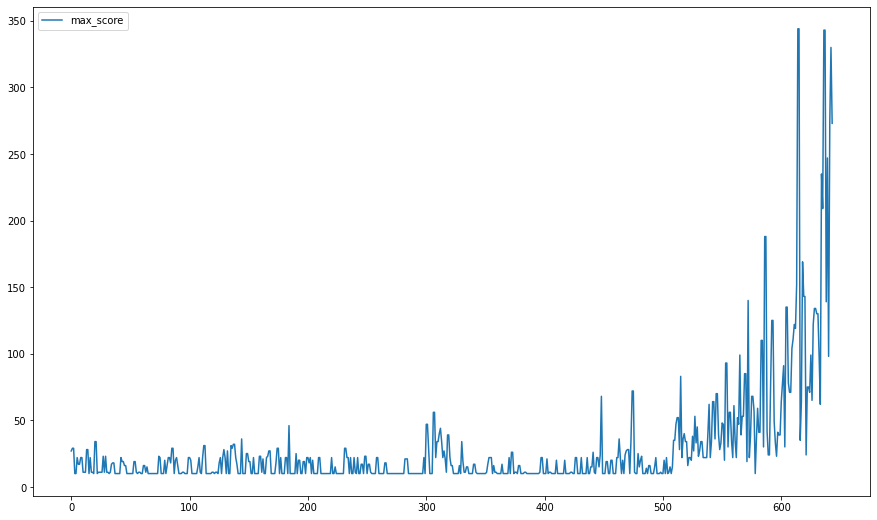

In [140]:
import pandas as pd
start = 0
interval = 10
scores_df = pd.read_csv("./objects/scores_df.csv")
mean_scores = pd.DataFrame(columns =['score'])
actions_df = pd.read_csv("./objects/actions_df.csv")
max_scores = pd.DataFrame(columns =['max_score'])
q_max_scores = pd.DataFrame(columns =['q_max'])
while interval <= len(scores_df):
    mean_scores.loc[len(mean_scores)] = (scores_df.loc[start:interval].mean()['scores'])
    max_scores.loc[len(max_scores)] = (scores_df.loc[start:interval].max()['scores'])
    start = interval
    interval = interval + 2

q_max_df = pd.read_csv("./objects/q_values.csv")

start = 0
interval = 1000
# while interval <=len(q_max_df):
#     q_max_scores.loc[len(q_max_scores)] = (q_max_df.loc[start:interval].mean()['actions'])
#     start = interval
#     interval = interval + 1000
    
mean_scores.plot()
max_scores.plot()
# q_max_scores.plot()